# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize
import scipy.integrate
import scipy.interpolate

%matplotlib inline

from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

from IPython.display import Math, Latex, display, Image

plt.style.use('lato_style.mplstyle')

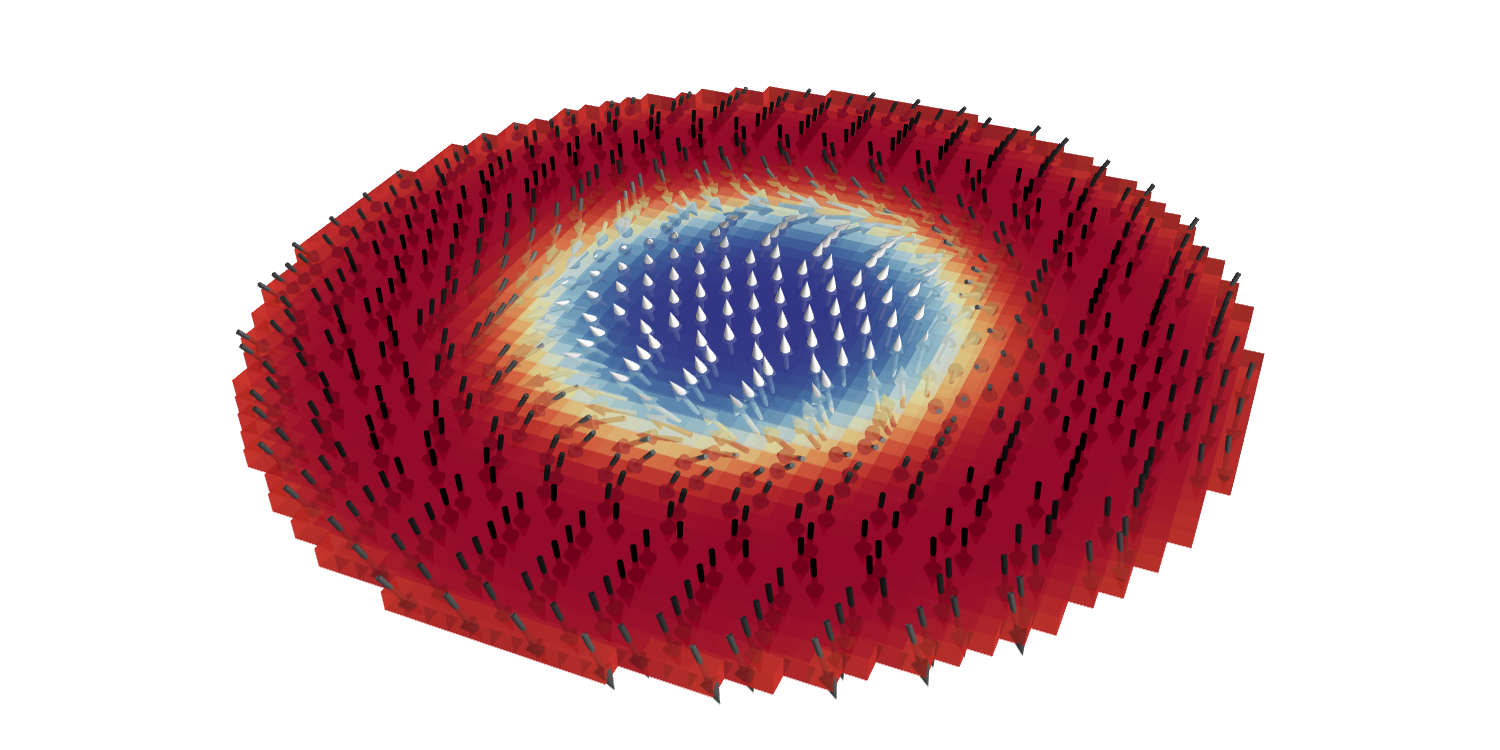

In [2]:
Image('mayavi/system_2d.png')

# Skyrmion in a disk

Two dimensional standard problem for the *Proposal for a micromagnetic standard problem for materials with Dzyaloshinskii-Moriya interaction* paper.

System:


    * A permalloy-like 2D nanodisk of 100 nm diameter of width (xy plane) and 1 nm of thickness (along z direction)
    * Interactions: Exchange:                    13e-12  J m**-1
                    DMI:                         3e-3    J m**-2
                    Uniaxial Anisotropy along z: 0.4e6   J m**-3
                    Ms:                          0.86    MA m**-1
                    
                    
Here we compare skyrmion solutions in systems with different DMI types.

In [3]:
# System parameters
nm = 1e-9
radius = 50 * nm        # sample radius in nm
thickness = 2 * nm
cell = 2 * nm

# scales in nm
radius_s = radius / nm
thickness_s = thickness / nm
cell_s = cell / nm

# Permalloy-like material (for testing purposes)
A = 13e-12
D = 3e-3
Ku = 0.4e6
Ms = 0.86e6

print('H_D = ', (1e9) * 4 * np.pi * A / D, ' nm')

H_D =  54.454272662223076  nm


# OOMMF Simulation

In [4]:
%%capture
import oommfc as oc
import discretisedfield as df
plt.style.use('lato_style.mplstyle')

Define a nanodisk system by making a cuboid finite differences mesh and setting $M_{s}$ as zero outside a circular region of 50 nm radius. Skyrmion solutions are metastable in for the chosen DMI, thus we set a singularity as the initial state to obtain a skyrmion.

In OOMMF, we use opposite sign for the DMIs to obtain solutions similar to Fidimag. This only changes the chirality of the configurations. Energy and topology are still equivalent.

We will simulate three systems with DMI by saving every simulation object in the `systems` list, in the following order: $C_{nv}$, $T$, $D_{2d}$

In [5]:
mesh = oc.Mesh(p1=(-radius, -radius, 0), p2=(radius, radius, thickness), 
               cell=(cell, cell, cell))

systems = [None, None, None]

DMS = [D, D, D]
for i, dmi in enumerate(['Cnv', 'T', 'D2d']):

    systems[i] = oc.System(name='oommf_2D_' + dmi)
    # Add interactions
    systems[i].hamiltonian = oc.Exchange(A=A) + oc.DMI(D=DMS[i], crystalclass=dmi) + \
                             oc.UniaxialAnisotropy(K1=Ku, u=(0, 0, 1))

# To define the nanodisk:
def Ms_fun(pos):
    x, y, z = pos
    if (x ** 2 + y ** 2) ** 0.5 < radius:
        return Ms
    else:
        return 0

# Make spins point in the opposite direction in a small circular region at
# the middle of the sample to get a skyrmion
def m_init(pos):
    x, y, z = pos
    if (x ** 2 + y ** 2) ** 0.5 < radius / 2:
        return (0, 0.1, 1)
    else:
        return (0, 0.1, -1)

for i in range(3):
    systems[i].m = df.Field(mesh, value=m_init, norm=Ms_fun)

The initial state for the $D_{2d}$ simulation (and the others as well) looks like:

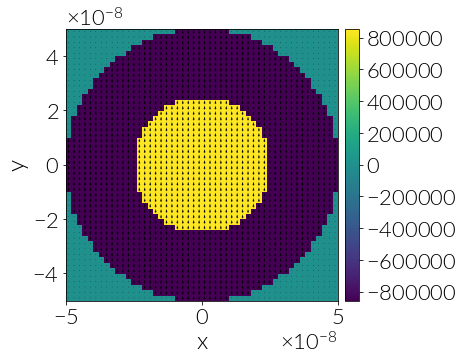

In [6]:
systems[2].m.plot_plane('z')

Now relax the systems to obtain a metastable skyrmion. We plot the solution after relaxation of every simulation, where we recognise the Neel-skyrmion, Bloch-skyrmion and anti-skyrmion

2018/3/27 10:9: Calling OOMMF (oommf_2D_Cnv/oommf_2D_Cnv.mif) ... [0.6s]
2018/3/27 10:9: Calling OOMMF (oommf_2D_T/oommf_2D_T.mif) ... [0.6s]
2018/3/27 10:9: Calling OOMMF (oommf_2D_D2d/oommf_2D_D2d.mif) ... [0.6s]


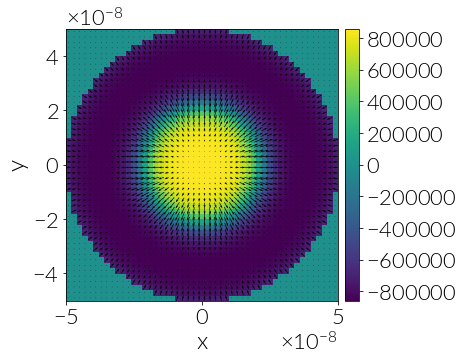

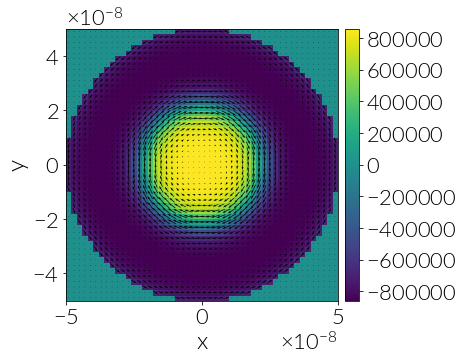

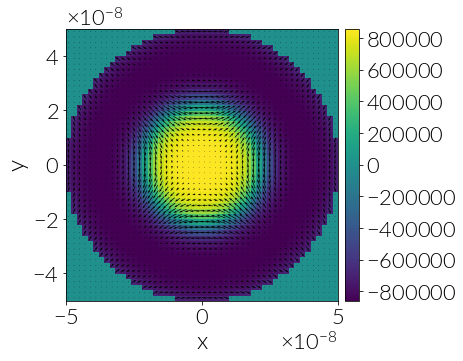

In [7]:
md = oc.MinDriver()

for i in range(3):
    md.drive(systems[i])
    systems[i].m.plot_plane('z')

We now save the magnetisation and coordinates to analyse the data and later compare with the other softwares:

In [8]:
# A list of tuples with the coordinates in the order of systems[2]
coordinates = list(systems[2].m.mesh.coordinates)

# Turn coordinates into a (N, 3) array and save in corresponding variables
# scaled in nm
coordinates = np.array(coordinates)
x_oommf, y_oommf, z_oommf = coordinates[:, 0] * 1e9, coordinates[:, 1] * 1e9, coordinates[:, 2] * 1e9
phi_oommf = np.arctan2(y_oommf, x_oommf)

# for m , make a list of (3, 5) elements, where every row is one of the systems 
# (Cnv, T and D2d) and every column is a component of the magnetisation
# in the order: mx my mz mr mphi
m_oommf = [[None for i in range(5)] for j in range(3)]

# Now start saving the data for every simulation (Cnv, T, D2d):
for i in range(3):
    
    # Get the magnetisation for every coordinate in the magnetisation list
    values = []
    for c in coordinates:
        values.append(systems[i].m(c))
    values = np.array(values)

    # Save them in the corresponding row and column of the m list
    # mx, my, mz:
    m_oommf[i][0], m_oommf[i][1], m_oommf[i][2] = (values[:, 0] / Ms, 
                                                   values[:, 1] / Ms,
                                                   values[:, 2] / Ms
                                                   )
    
    mx, my, mz = m_oommf[i][0], m_oommf[i][1], m_oommf[i][2]
    
    # Now save mr and mphi:
    m_oommf[i][3] = mx * np.cos(phi_oommf) + my * np.sin(phi_oommf)
    m_oommf[i][4] = -mx * np.sin(phi_oommf) + my * np.cos(phi_oommf)

We can compute the skyrmion radius, where $m_{z}=0$, for every simulation ($C_{nv}$, $T$, $D_{2d}$). They should be equivalent, thus we use the `r_sk` variable from the last simulation in the loop.

In [9]:
xs, ys = np.unique(x_oommf), np.unique(y_oommf)
_filter_y = y_oommf == ys[int(len(ys) * 0.5)]

DMS = ['interfacial', 'bulk', 'D2d']
for i in range(3):
    f = scipy.interpolate.interp1d(x_oommf[_filter_y], m_oommf[i][2][_filter_y], kind='cubic')
    # Skyrmion radius: m_z = 0
    r_sk_oommf = scipy.optimize.brentq(f, 0, 48)
    print('r_sk [{:<12}] = {:.4f}'.format(DMS[i], r_sk_oommf))

r_sk [interfacial ] = 21.8708
r_sk [bulk        ] = 21.8708
r_sk [D2d         ] = 21.8708


At $r=r_{\text{sk}}$, the $z$ component of $\mathbf{m}$ is zero. We will extract the $m_{r}$ component at $r=r_{\text{sk}}$ and plot it as a function of the azimuthal angle $\phi$. We see that the skyrmion has a different radial profile for different DMIs. At this radius, the components for the skyrmion in the $C_{nv}$ system is always 1 (fully radial), for the $T$ class is zero (vortex-like), and for $D_{2d}$ is $\sin2\phi$, which can be computed by wriitng the $\mathbf{m}$ in spherical coordinates dependant on cylindrical spatial coordinates.

Text(0.5,0,'$\\phi$')

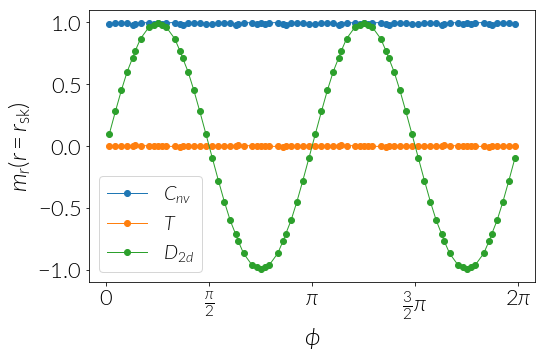

In [10]:
mr_ring_oommf = [None for i in range(3)]
phi_ring_oommf = [None for i in range(3)]

DMS = [r'$C_{nv}$', r'$T$', r'$D_{2d}$']
for i in range(3):
    
    # Save mx, my, mz components and compute the norm
    # We filter mesh sites with zero magnetic moment norm (no material)
    mx, my, mz = m_oommf[i][0], m_oommf[i][1], m_oommf[i][2]
    m = np.sqrt(mx ** 2 + my ** 2 + mz ** 2)
    m_filter = m > 1e-5
    
    # Make an array filter for spins at r = r_sk, after filtering sites
    # without material
    xf, yf = x_oommf[m_filter], y_oommf[m_filter]
    ring_filter = np.logical_and(xf ** 2 + yf ** 2 >= (r_sk_oommf - 1) ** 2, 
                                 xf ** 2 + yf ** 2 <= (r_sk_oommf + 1) ** 2) 

    # Extract the phi coordinates for points at r=r_sk and shift the angles
    phi_ring = phi_oommf[m_filter][ring_filter]
    phi_ring[phi_ring < 0] += 2 * np.pi

    # Get mr and mphi at r=r_sk in sites with material (|m| != 0)
    mr_ring =  m_oommf[i][3][m_filter][ring_filter]
    mphi_ring =  m_oommf[i][4][m_filter][ring_filter]

    # Sort the mr array according to the order of the sorted phi array
    mr_ring_sorted = [x for _, x in sorted(zip(phi_ring, mr_ring), 
                                            key=lambda pair: pair[0])]
    
    # plot the sorted phi and mr at r = r_sk
    plt.plot(sorted(phi_ring), mr_ring_sorted, 'o-', linewidth=1, label=DMS[i])
    
    # Save the data
    mr_ring_oommf[i] = mr_ring_sorted
    phi_ring_oommf[i] = sorted(phi_ring)


plt.ylim(-1.1, 1.1)
plt.ylabel(r'$m_{r}(r=r_{\mathrm{sk}})$')
plt.legend()
plt.xticks([0., .5 * np.pi, np.pi, 1.5 * np.pi, 2 * np.pi])
plt.gca().set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$",
                           r"$\frac{3}{2}\pi$", r"$2\pi$"])
plt.xlabel(r'$\phi$')

# Fidimag Simulation

We can do a similar analysis with Fidimag simulations:

In [11]:
import fidimag

In [12]:
dx, dy, dz = cell_s, cell_s, cell_s
nx, ny, nz = int(2 * radius_s / dx), int(2 * radius_s / dy), 1
mesh = fidimag.common.CuboidMesh(dx=dx, dy=dy, dz=dz, nx=nx, ny=ny, nz=nz,
                                 unit_length=1e-9)

# 3 Simulations: interfacial, bulk and D2d DMI
sims = [None] * 3
sims[0] = fidimag.micro.Sim(mesh, name='fidimag_2D_int')
sims[1] = fidimag.micro.Sim(mesh, name='fidimag_2D_bulk')
sims[2] = fidimag.micro.Sim(mesh, name='fidimag_2D_D2d')

# To define the nanodisk:
def Ms_fun(pos):
    x, y = np.array(pos)[:2] - radius_s
    if (x ** 2 + y ** 2) ** 0.5 < radius_s:
        return Ms
    else:
        return 0

# Make spins point in the opposite direction in a small circular region at
# the middle of the sample to get a skyrmion
def m_init(pos):
    x, y = np.array(pos)[:2] - radius_s
    if (x ** 2 + y ** 2) ** 0.5 < radius_s / 2:
        return (0, 0.1, 1)
    else:
        return (0, 0.1, -1)

for i in range(3): 
    sims[i].set_Ms(Ms_fun)
    sims[i].set_m(m_init)
    sims[i].add(fidimag.micro.UniformExchange(A=A))
    sims[i].add(fidimag.micro.UniaxialAnisotropy(Ku, axis=(0, 0, 1)))
    
sims[0].add(fidimag.micro.DMI(D=D, dmi_type='interfacial'))
sims[1].add(fidimag.micro.DMI(D=D, dmi_type='bulk'))
sims[2].add(fidimag.micro.DMI(D=D, dmi_type='D_2d'))

In [13]:
%%capture

for i in range(3):
    sims[i].driver.do_precession = False
    sims[i].driver.alpha = 0.9
    # sims[i].driver.set_tols(1e-10, 1e-10)
    sims[i].relax(stopping_dmdt=.01)

In [14]:
# Compute center in x and y
xs, ys = np.unique(mesh.coordinates[:, 0]), np.unique(mesh.coordinates[:, 1])
center_x = (xs.max() - xs.min()) * 0.5 + xs.min()
center_y = (ys.max() - ys.min()) * 0.5 + ys.min()

r_fidimag = mesh.coordinates
r_fidimag[:, 0] -= center_x
r_fidimag[:, 1] -= center_y

# We will mask the array to extract only the spins at y=y_mid (middle of the sample)
xs, ys = np.unique(r_fidimag[:, 0]), np.unique(r_fidimag[:, 1])


# _filter_x = r_fidimag[:, 0] == xs[int(len(xs) * 0.5)]

m_fidimag = [[None for i in range(3)] for i in range(3)]

for i in range(3):
    m_fidimag[i][0] = sims[i].spin.reshape(-1, 3)[:, 0]
    m_fidimag[i][1] = sims[i].spin.reshape(-1, 3)[:, 1]
    m_fidimag[i][2] = sims[i].spin.reshape(-1, 3)[:, 2]

x_fidimag, y_fidimag, z_fidimag = r_fidimag[:, 0], r_fidimag[:, 1], r_fidimag[:, 2]

We can now extract the data from the middle of the disk:

(-1, 1)

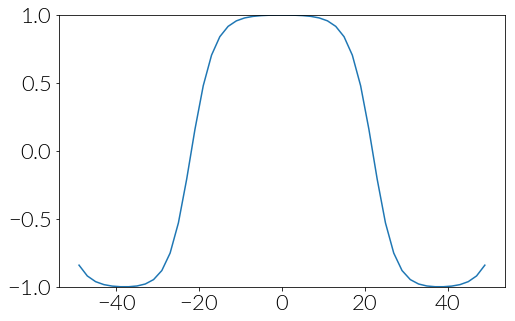

In [15]:
# plt.plot(r_fidimag[:, 1][_filter_x] - 50, sim.spin.reshape(-1, 3)[:, 2][_filter_x])
_filter_y = r_fidimag[:, 1] == ys[int(len(ys) * 0.5)]
plt.plot(x_fidimag[_filter_y], m_fidimag[0][2][_filter_y])
plt.ylim(-1, 1)

We can show the relaxed state by filtering sites without material, i.e. where $M_{\text{s}}=0$ 

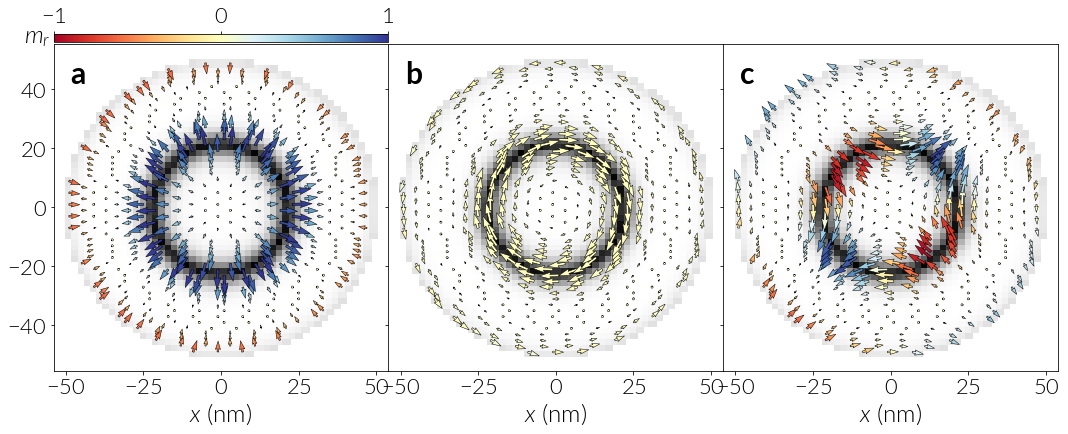

In [16]:
m_filter = sims[0].Ms > 1e-5

x, y = r_fidimag[:, 0], r_fidimag[:, 1]
phi = np.arctan2(y, x)

f, axs = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)

labs = ['a', 'b', 'c']
for i in range(3):
    mx, my, mz = m_fidimag[i][0], m_fidimag[i][1], m_fidimag[i][2]
    mr = mx * np.cos(phi) + my * np.sin(phi)
    
    axs[i].scatter(x[m_filter], y[m_filter], 
                   c=np.abs(mz[m_filter]),
                   vmin=0, vmax=1,
                   s=55, marker='s', cmap='Greys_r')

    rf = np.random.randint(2, size=len(x[m_filter])).astype(np.bool)
    stride=4
    axs[i].quiver(x[m_filter][::stride],
                  y[m_filter][::stride], 
                  mx[m_filter][::stride],
                  my[m_filter][::stride],
                  mr[m_filter][::stride],
                  width=0.007, scale=1 / 0.06, 
                  headwidth=3, headlength=5,
                  minshaft=1.3,
                  edgecolor='k', 
                  linewidth=0.5,
                  cmap='RdYlBu',
                  clim=(-1, 1)
                  )
    axs[i].set_xlabel(r'$x$ (nm)')
    # axs[i].set_ylabel(r'$y$ (nm)')
    
    axs[i].text(0.05, 0.95, labs[i], fontweight='bold', fontsize=30,
                horizontalalignment='left', verticalalignment='top', 
                transform=axs[i].transAxes)

# -----------------------------------------------------------------------------

# Colorbar
box = axs[0].get_position()
axColor = plt.axes([box.x0, box.y1 + 0.005, box.width + 0.03, 0.02])
cb = plt.colorbar(axs[0].get_children()[1], cax=axColor, orientation="horizontal")
cb.set_ticks([-1, 0, 1])
# Put the colorbar labels to the left:
cb.ax.xaxis.set_ticks_position('top')
cb.set_label(r'$m_{r}$', fontsize=24, rotation=0, labelpad=-15, x=-0.05)
# -----------------------------------------------------------------------------

plt.subplots_adjust(wspace=0)

# plt.savefig('result_2d_sk-profiles_fidimag.pdf', bbox_inches='tight')

An HLS colourmap allows a full visualisation of the three components of the magnetisation field:

In [17]:
import colorsys

def convert_to_rgb(hls_color):
    return np.array(colorsys.hls_to_rgb(hls_color[0] / (2 * np.pi),
                                         hls_color[1],
                                         hls_color[2]))
def generate_rgbs(field_data):
    """
    field_data      ::  (n, 3) array
    """
    hls = np.ones_like(field_data)
    hls[:, 0] = np.arctan2(field_data[:, 1],
                           field_data[:, 0]
                           )
    hls[:, 0][hls[:, 0] < 0] = hls[:, 0][hls[:, 0] < 0] + 2 * np.pi
    hls[:, 1] = 0.5 * (field_data[:, 2] + 1)
    rgbs = np.apply_along_axis(convert_to_rgb, 1, hls)

    # Some RGB values can get very small magnitudes, like 1e-10:
    rgbs[rgbs < 0] += 2 * np.pi

    return rgbs

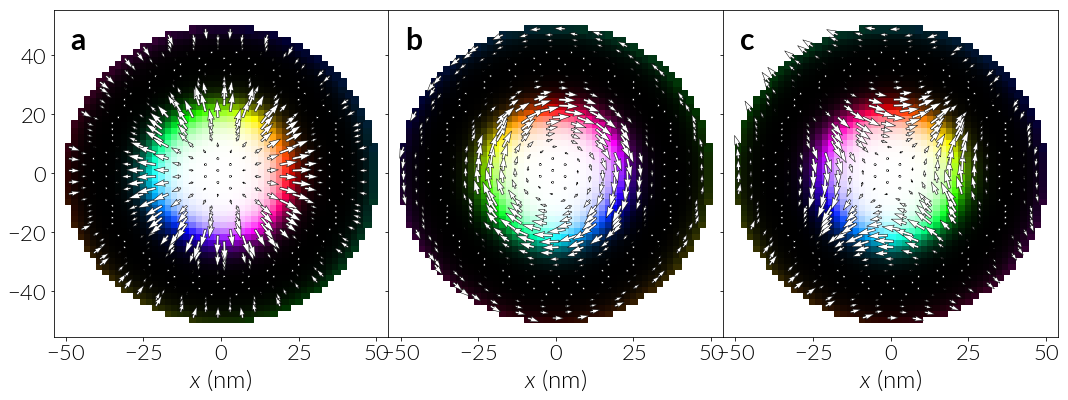

In [18]:
m_filter = sims[0].Ms > 1e-5

x, y = r_fidimag[:, 0], r_fidimag[:, 1]
phi = np.arctan2(y, x)

f, axs = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)

labs = ['a', 'b', 'c']
for i in range(3):
    mx, my, mz = m_fidimag[i][0], m_fidimag[i][1], m_fidimag[i][2]
    mr = mx * np.cos(phi) + my * np.sin(phi)
    
    axs[i].scatter(x[m_filter], y[m_filter], 
                   c=generate_rgbs(sims[i].spin.reshape(-1, 3)[[m_filter]]),
                   vmin=0, vmax=1,
                   s=55, marker='s', 
                   # cmap='hsl'
                   )

    # rf = np.random.randint(2, size=len(x[m_filter])).astype(np.bool)
    rf = slice(0, -1, 4)
    axs[i].quiver(x[m_filter][rf],
                  y[m_filter][rf], 
                  mx[m_filter][rf],
                  my[m_filter][rf],
                  # mr[m_filter][::stride],
                  width=0.007, scale=1 / 0.06, 
                  headwidth=3, headlength=5,
                  minshaft=1.3,
                  edgecolor='k', 
                  linewidth=0.5,
                  # cmap='RdYlBu',
                  # clim=(-1, 1)
                  facecolor='white'
                  )
    axs[i].set_xlabel(r'$x$ (nm)')
    # axs[i].set_ylabel(r'$y$ (nm)')
    
    axs[i].text(0.05, 0.95, labs[i], fontweight='bold', fontsize=30,
                horizontalalignment='left', verticalalignment='top', 
                transform=axs[i].transAxes)

# -----------------------------------------------------------------------------
# Colorbar
# box = axs[0].get_position()
# axColor = plt.axes([box.x0, box.y1 + 0.005, box.width, 0.01])
# cb = plt.colorbar(axs[0].get_children()[1], cax=axColor, orientation="horizontal")
# cb.set_ticks([-1, 0, 1])
# # Put the colorbar labels to the left:
# cb.ax.xaxis.set_ticks_position('top')
# cb.set_label(r'$m_{r}$', fontsize=24, rotation=0, labelpad=-15, x=-0.05)
# -----------------------------------------------------------------------------

plt.subplots_adjust(hspace=0, wspace=0)

# plt.savefig('result_2d_sk-profiles_fidimag.pdf', bbox_inches='tight')

## Analysing components where $r = r_{\text{sk}}$

Skyrmion radius:

In [19]:
x, y = r_fidimag[:, 0], r_fidimag[:, 1]
phi = np.arctan2(y, x)

In [20]:
xs, ys = np.unique(x), np.unique(y)
_filter_y = y == ys[int(len(ys) * 0.5)]

DMS = ['Cnv', 'T', 'D2d']
for i in range(3):
    f = scipy.interpolate.interp1d(x[_filter_y], m_fidimag[i][2][_filter_y], kind='cubic')
    # Skyrmion radius: m_z = 0
    r_sk_fidimag = scipy.optimize.brentq(f, 0, 48)
    print('r_sk [{:<3}] = {:.4f}'.format(DMS[i], r_sk_fidimag))

r_sk [Cnv] = 21.8708
r_sk [T  ] = 21.8715
r_sk [D2d] = 21.8703


In [21]:
xf, yf = x[m_filter], y[m_filter]

ring_filter = np.logical_and(xf ** 2 + yf ** 2 >= (r_sk_fidimag - 1) ** 2, 
                             xf ** 2 + yf ** 2 <= (r_sk_fidimag + 1) ** 2)

Text(0,0.5,'$m_{r}(r=r_{\\mathrm{sk}})$')

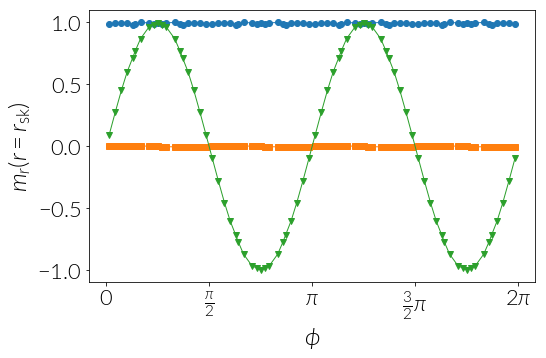

In [22]:
mr_ring_fidimag = [None for i in range(3)]
phi_ring_fidimag = [None for i in range(3)]

plt.figure()

marks = ['o', 's', 'v']
for i in range(3):
    mx, my, mz = m_fidimag[i][0], m_fidimag[i][1], m_fidimag[i][2]

    mr = mx * np.cos(phi) + my * np.sin(phi)
    mphi = -mx * np.sin(phi) + my * np.cos(phi)

    phi_ring = phi[m_filter][ring_filter]
    phi_ring[phi_ring < 0] += 2 * np.pi
    
    mx_ring =  mx[m_filter][ring_filter]
    mz_ring =  mz[m_filter][ring_filter]
    mr_ring =  mr[m_filter][ring_filter]
    mphi_ring =  mphi[m_filter][ring_filter]

    # print(mx_ring)
    mr_ring_sorted = [x for _, x in sorted(zip(phi_ring, mr_ring), 
                                            key=lambda pair: pair[0])]
    plt.plot(sorted(phi_ring), mr_ring_sorted, marker=marks[i], linewidth=1)
    
    # Save the data
    mr_ring_fidimag[i] = mr_ring_sorted
    phi_ring_fidimag[i] = sorted(phi_ring)


plt.xticks([0., .5 * np.pi, np.pi, 1.5 * np.pi, 2 * np.pi])
plt.gca().set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$",
                           r"$\frac{3}{2}\pi$", r"$2\pi$"])

plt.xlabel(r'$\phi$')
plt.ylabel(r'$m_{r}(r=r_{\mathrm{sk}})$')

# MuMax 3 results

By running the MuMax3 simulations we can analyse the output data, which has a similar structure than OOMMF files:

In [23]:
import pandas as pd

In [24]:
mumax_data = [None, None, None]

for i, dmi in enumerate(['Inter', 'Bulk', 'D2d']):
    mumax_data[i] = pd.read_csv('../sims/MUMAX3/2D/Skyrmion-{}.ovf'.format(dmi), 
                                comment='#', header=None, delim_whitespace=True)
    mumax_data[i] = mumax_data[i].as_matrix()

In [25]:
# A list of tuples with the coordinates in the order of mumax_data
coordinates = mumax_data[0][:, :3]

# Compute center in x and y
xs, ys = np.unique(coordinates[:, 0]), np.unique(coordinates[:, 1])
center_x = (xs.max() - xs.min()) * 0.5 + xs.min()
center_y = (ys.max() - ys.min()) * 0.5 + ys.min()

# Save in corresponding variables scaled in nm and compute w/r to the sample center
x_mumax, y_mumax, z_mumax = (coordinates[:, 0] * 1e9 - center_x * 1e9, 
                             coordinates[:, 1] * 1e9 - center_y * 1e9, 
                             coordinates[:, 2] * 1e9
                             )
phi_mumax = np.arctan2(y_mumax, x_mumax)

# for m , make a list of (3, 5) elements, where every row is one of the systems 
# (Cnv, T and D2d) and every column is a component of the magnetisation
# in the order: mx my mz mr mphi
m_mumax = [[None for i in range(5)] for j in range(3)]

# Now start saving the data for every simulation (Cnv, T, D2d):
for i in range(3):
    
    # Save them in the corresponding row and column of the m list
    # mx, my, mz:
    m_mumax[i][0], m_mumax[i][1], m_mumax[i][2] = (mumax_data[i][:, 3], 
                                                   mumax_data[i][:, 4],
                                                   mumax_data[i][:, 5]
                                                   )
    
    mx, my, mz = m_mumax[i][0], m_mumax[i][1], m_mumax[i][2]
    # Now save mr and mphi:
    m_mumax[i][3] = mx * np.cos(phi_mumax) + my * np.sin(phi_mumax)
    m_mumax[i][4] = -mx * np.sin(phi_mumax) + my * np.cos(phi_mumax)

The skyrmion radius for every DMI system:

In [26]:
xs, ys = np.unique(x_mumax), np.unique(y_mumax)
_filter_y = y_mumax == ys[int(len(ys) * 0.5)]

DMS = ['Cnv', 'T', 'D2d']
for i in range(3):
    f = scipy.interpolate.interp1d(x_mumax[_filter_y], m_mumax[i][2][_filter_y], kind='cubic')
    # Skyrmion radius: m_z = 0
    r_sk_mumax = scipy.optimize.brentq(f, 0, 48)
    print('r_sk [{:<3}] = {:.4f}'.format(DMS[i], r_sk_mumax))

r_sk [Cnv] = 22.0938
r_sk [T  ] = 22.0979
r_sk [D2d] = 22.0939


Plot the components ar $r=r_{\text{sk}}$

Text(0.5,0,'$\\phi$')

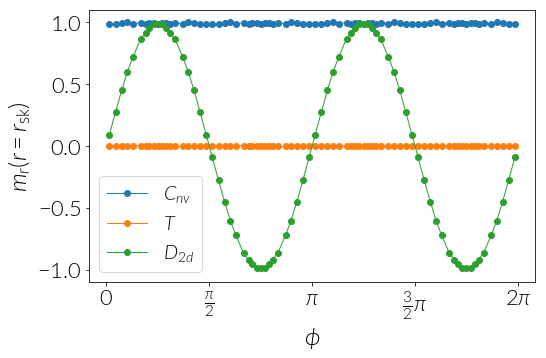

In [27]:
mr_ring_mumax = [None for i in range(3)]
phi_ring_mumax = [None for i in range(3)]

DMS = [r'$C_{nv}$', r'$T$', r'$D_{2d}$']
for i in range(3):
    
    # Save mx, my, mz components and compute the norm
    # We filter mesh sites with zero magnetic moment norm (no material)
    mx, my, mz = m_mumax[i][0], m_mumax[i][1], m_mumax[i][2]
    m = np.sqrt(mx ** 2 + my ** 2 + mz ** 2)
    m_filter = m > 1e-5
    
    # Make an array filter for spins at r = r_sk, after filtering sites
    # without material
    xf, yf = x_mumax[m_filter], y_mumax[m_filter]
    ring_filter = np.logical_and(xf ** 2 + yf ** 2 >= (r_sk_mumax - 1) ** 2, 
                                 xf ** 2 + yf ** 2 <= (r_sk_mumax + 1) ** 2) 

    # Extract the phi coordinates for points at r=r_sk and shift the angles
    phi_ring = phi_mumax[m_filter][ring_filter]
    phi_ring[phi_ring < 0] += 2 * np.pi

    # Get mr and mphi at r=r_sk in sites with material (|m| != 0)
    mr_ring =  m_mumax[i][3][m_filter][ring_filter]
    mphi_ring =  m_mumax[i][4][m_filter][ring_filter]

    # Sort the mr array according to the order of the sorted phi array
    mr_ring_sorted = [x for _, x in sorted(zip(phi_ring, mr_ring), 
                                            key=lambda pair: pair[0])]
    
    # plot the sorted phi and mr at r = r_sk
    plt.plot(sorted(phi_ring), mr_ring_sorted, 'o-', linewidth=1, label=DMS[i])
    
    # Save the data
    mr_ring_mumax[i] = mr_ring_sorted
    phi_ring_mumax[i] = sorted(phi_ring)


plt.ylim(-1.1, 1.1)
plt.ylabel(r'$m_{r}(r=r_{\mathrm{sk}})$')
plt.legend()
plt.xticks([0., .5 * np.pi, np.pi, 1.5 * np.pi, 2 * np.pi])
plt.gca().set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$",
                           r"$\frac{3}{2}\pi$", r"$2\pi$"])
plt.xlabel(r'$\phi$')

# ODE Solution

The differential equation to obtain skyrmion-like solutions in nanodisks has been published in several papers. We define the magnetisation as

$$
\mathbf{m} = (\sin\theta\cos\psi,\sin\theta\sin\psi,\cos\theta) \,,
$$

where $\theta,\psi$ are n cylindrical coordinates, i.e. $\theta = \theta(r,\phi,z)$ (same for $\psi$).

For interfacial DMI, the system accepts solutions in the form $\psi=\phi$ with a variational equation for $\theta$ in the form:

$$
\begin{eqnarray}
\frac{\text{d}^2 \theta}{\text{d}r^2} & = & -\frac{1}{r} \frac{\text{d}\theta}{\text{d}r} 
                                            + \frac{\sin2\theta}{2}\left(\frac{1}{r^2} + \frac{1}{\Delta^2} \right)
                                            + \frac{2\sin^{2}\theta}{\xi r} & \\
\frac{\text{d}\theta}{\text{d}r} & = & \frac{1}{\xi} & \text{for } r=R \,.
\end{eqnarray}
$$

Here $\Delta=\sqrt{2A/K}$, $\xi=2A/D$ and the system has been defined in the $r\in[0, R]$ range. The initial value at the centre of the disk is defined as $\theta(r=0)=0$. We can solve this equation using the shooting method to match the condition of the derivative at the $r=R$ boundary, i.e. we try a set of $\theta'(r=0)$ initial values and find the one that satisfies the condition at $r=R$.

In [28]:
# Use units in the nm scale
delta = (np.sqrt(A / Ku)) / nm
xi = (2 * A / D) / nm 

r_array = np.linspace(1e-15, radius_s, 500)


def ode_2d(theta, r):
    '''
    ODE for boundary value problem (function given at r = 0, derivative of 
    function given at r = R )
    '''
    return np.array([theta[1],
                     -theta[1] / r + 0.5 * np.sin(2 * theta[0]) * ((1 / r ** 2) + (1 / delta ** 2)) 
                     + 2 * (np.sin(theta[0]) ** 2) / (xi * r)])


# Define a function to solve the differential equation in the (0, R) range
# for any theta'(r=0) condition. We need theta'(r=R) = 1/xi
# The function returns the difference of theta' with respect to the desired solution at r=R
def solve_ode(a):
    solution, info = scipy.integrate.odeint(ode_2d, [0, a], r_array, full_output=True)
    return solution[:, 1][-1] - (1 / xi)

Text(0.5,0,"$\\theta'(0)$")

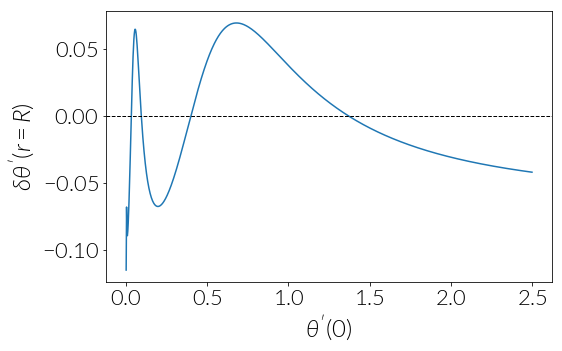

In [29]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(8, 8 / 1.6))

aa = np.linspace(0, 2.5, 1000)
guesses = [solve_ode(a) for a in aa]

plt.plot(aa, guesses)
plt.axhline(y=0, ls='--', lw=1, color='k')
plt.ylabel(r"$\delta\theta'(r=R)$")
plt.xlabel(r"$\theta'(0)$")

We need the root of this difference, i.e. $\delta\theta'(r=R)=0$ which satisfies the ODE with the desired conditions, thus we use Scipy's `brentq` root-finder. We must notice that there are multiple zeros, indicating different solutions:

In [30]:
# Find the root from the differences:
guess = []
guess.append(scipy.optimize.brentq(solve_ode, 0, 0.05))
guess.append(scipy.optimize.brentq(solve_ode, 0.05, 0.2))
guess.append(scipy.optimize.brentq(solve_ode, 0.2, 0.7))
guess.append(scipy.optimize.brentq(solve_ode, 1.0, 2))
guess

[0.03168718977922677,
 0.09339123850204234,
 0.39841600800533894,
 1.370472723157511]

In [31]:
solutions = []

for g in guess:
    solution, info = scipy.integrate.odeint(ode_2d, [0, g], r_array, full_output=True)
    solutions.append(solution)

We can now plot the solutions for different initial conditions:

Text(0.5,0,'$r$ (nm)')

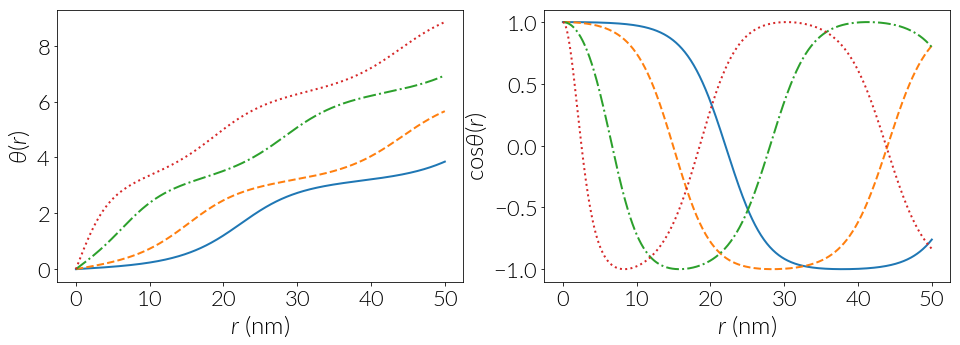

In [32]:
styles = ['-', '--', '-.', ':']
f = plt.figure(figsize=(16, 8/1.6))

ax = f.add_subplot(121)
for i, s in enumerate(solutions):
    ax.plot(r_array, s[:, 0], ls=styles[i], lw=2)
ax.set_ylabel(r"$\theta(r)$")
ax.set_xlabel(r"$r$ (nm)")

ax2 = f.add_subplot(122)
for i, s in enumerate(solutions):
    ax2.plot(r_array, np.cos(s[:, 0]), ls=styles[i], lw=2)
ax2.set_ylabel(r"$\cos\theta(r)$")
ax2.set_xlabel(r"$r$ (nm)")

The first solution is a skyrmion where we recognise the spin canting at the $r=R$ boundary. The other solutions are multiple cycloidal states. 

We can also compute the skyrmion radius from the analytical solution:

In [33]:
f = scipy.interpolate.interp1d(r_array, np.cos(solutions[0][:, 0]), kind='cubic')
# Skyrmion radius: m_z = 0
r_sk_ode = scipy.optimize.brentq(f, 1, 49)
print('r_sk ODE = ', r_sk_ode)

r_sk ODE =  22.030392761381712


# Comparison with simulations

We can compare the interpolation of the $m_{z}$ profile close to where $m_{z}=0$ to check the discrepancy in the skyrmion radius values. Since OOMMF and Fidimag produce similar skyrmion radius values, we only show the latter.

Text(0.5,0,'$x$ (nm)')

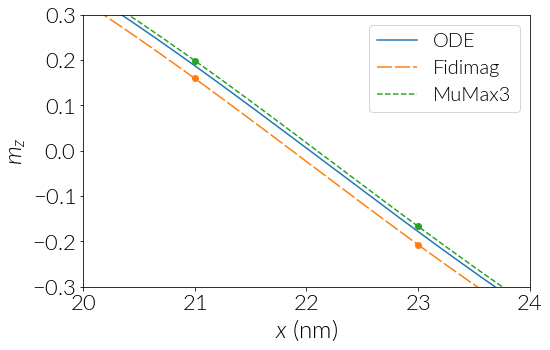

In [34]:
ft = scipy.interpolate.interp1d(r_array, np.cos(solutions[0][:, 0]), kind='cubic')
plt.plot(r_array, ft(r_array), label='ODE')

# Fidimag
xs, ys = np.unique(x_fidimag), np.unique(y_fidimag)
_filter_y = y_fidimag == ys[int(len(ys) * 0.5)]
ff = scipy.interpolate.interp1d(x_fidimag[_filter_y], m_fidimag[0][2][_filter_y], kind='cubic')

r = np.linspace(1, 49, 1000)
plt.plot(r, ff(r), '--', dashes=(10, 2), label='Fidimag')
plt.plot(x_fidimag[_filter_y], m_fidimag[0][2][_filter_y], 'oC1')

# MuMax3

xs, ys = np.unique(x_mumax), np.unique(y_mumax)
_filter_y = y_mumax == ys[int(len(ys) * 0.5)]
fm = scipy.interpolate.interp1d(x_mumax[_filter_y], m_mumax[0][2][_filter_y], kind='cubic')

r = np.linspace(1, 48, 1000)
plt.plot(r, fm(r), '--', label='MuMax3')
plt.plot(x_mumax[_filter_y], m_mumax[0][2][_filter_y], 'oC2')

plt.xlim(20, 24)
plt.ylim(-0.3, 0.3)

plt.legend()
plt.ylabel(r'$m_{z}$')
plt.xlabel(r'$x$ (nm)')

Here we plot the skyrmion solution from the ODE results to compare with the simulations:

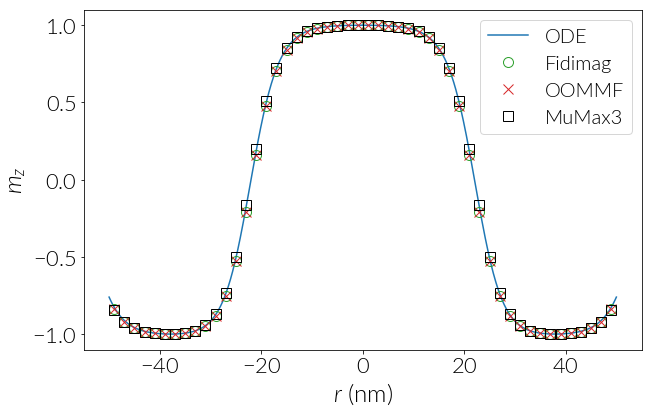

In [35]:
f, axs = plt.subplots(nrows=1, figsize=(10, 10 / 1.6))

# -----------------------------------------------------------------------------
# m_z profile
axs.plot(r_array, np.cos(solutions[0][:, 0]), color='C0', label='ODE')
axs.plot(-r_array[-1::-1], np.cos(solutions[0][:, 0])[-1::-1], color='C0')

# -----------------------------------------------------------------------------

xs, ys = np.unique(x_fidimag), np.unique(y_fidimag)
_filter_y = y_fidimag == ys[int(len(ys) * 0.5)]
axs.plot(x_fidimag[_filter_y], m_fidimag[0][2][_filter_y], 'oC2', label='Fidimag', markerfacecolor='None', ms=10)

# -----------------------------------------------------------------------------

xs, ys = np.unique(x_oommf), np.unique(y_oommf)
_filter_y = y_oommf == ys[int(len(ys) * 0.5)]
axs.plot(x_oommf[_filter_y], m_oommf[0][2][_filter_y], 'xC3', label='OOMMF', ms=10)

# -----------------------------------------------------------------------------

xs, ys = np.unique(x_mumax), np.unique(y_mumax)
_filter_y = y_mumax == ys[int(len(ys) * 0.5)]
axs.plot(np.array(x_mumax[_filter_y]), m_mumax[0][2][_filter_y], 'sk', label='MuMax3', ms=10, markerfacecolor='None')

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

# plt.xlim([0, R/1e-9])
plt.xlabel(r'$r$ (nm)')
plt.ylabel(r'$m_z$')
plt.legend(loc=0)
# plt.savefig('result_2d_mz-profile.pdf', dpi=300)

Here we plot the $m_{z}$ component using all the codes and the profiles of the cylindrical components from Fidimag simulations. We save the corresponding data when plotting the curves:

In [36]:
!mkdir -p data/results_2d

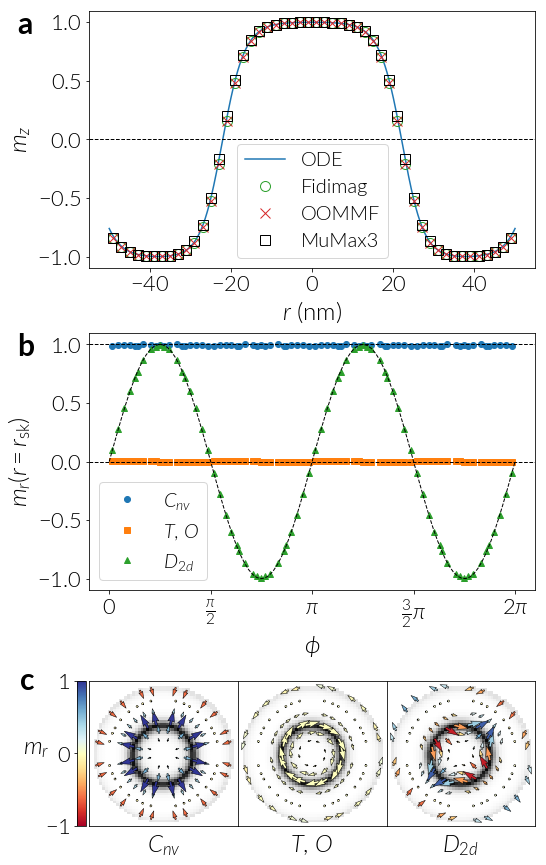

In [37]:
# Each plot has height = 7 (3 rows), the last row of plots has 3.5
f = plt.figure(figsize=(8, 16 / 1.6 + 8 / 1.6))
axs = [None] * 5
# Make outer gridspec
# We will design a: 2 X 1 grid of plots, and add a 1 X 3 grid at the bottom
# The bottom plots have half the height of a  normal plot, so we set
# 2 + 2 + 1 in heights  -> 5:1 ratio
outer = gridspec.GridSpec(2, 1, height_ratios = [4, 1])
# Separation of the bottom row of plots from the top grid
outer.update(hspace=0.25)

# Make nested gridspecs
# gs2 will be used to plot snapshots of three cut planes
# We set 2 for the height of the 2 X 1 grid since each of these plots span
# 1 unit of plots. We set the width as 9 since we divide gs2 in 3, thus
# gs1 is divided in 9 (3 rows)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 9, subplot_spec=outer[0], hspace=0.25)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 9, subplot_spec=outer[1], hspace=0., wspace=0)

# 2 X 1 grid of plots: heights span 1 unit and widths span 9 units
axs[1] = plt.subplot(gs1[1:, :9])
axs[0] = plt.subplot(gs1[:1, :9])

# 1 X 3 bottom row of plots: heights span 1 unit and widths 3 units
for j, i in enumerate(range(2, 5)):
    axs[i] = plt.subplot(gs2[:, j * 3:(j + 1) * 3])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

# -----------------------------------------------------------------------------

axs[0].plot(r_array, np.cos(solutions[0][:, 0]), color='C0', label='ODE')
axs[0].plot(-r_array[-1::-1], np.cos(solutions[0][:, 0])[-1::-1], color='C0')

np.savetxt('data/results_2d/result_2d_r-mz_interfacial_ODE.txt', np.column_stack((r_array, np.cos(solutions[0][:, 0]))))
np.savetxt('data/results_2d/result_2d_r-mz_interfacial_ODE_negative.txt', np.column_stack((-r_array[-1::-1], np.cos(solutions[0][:, 0])[-1::-1])))

# -----------------------------------------------------------------------------

xs, ys = np.unique(x_fidimag), np.unique(y_fidimag)
_filter_y = y_fidimag == ys[int(len(ys) * 0.5)]
axs[0].plot(x_fidimag[_filter_y], m_fidimag[0][2][_filter_y], 'oC2', 
            label='Fidimag', markerfacecolor='None', ms=10)
np.savetxt('data/results_2d/result_2d_r-mz_interfacial_fidimag.txt', np.column_stack((x_fidimag[_filter_y], m_fidimag[0][2][_filter_y])))

# -----------------------------------------------------------------------------

xs, ys = np.unique(x_oommf), np.unique(y_oommf)
_filter_y = y_oommf == ys[int(len(ys) * 0.5)]
axs[0].plot(x_oommf[_filter_y], m_oommf[0][2][_filter_y], 'xC3', 
            label='OOMMF', ms=10)
np.savetxt('data/results_2d/result_2d_r-mz_interfacial_oommf.txt', np.column_stack((x_oommf[_filter_y], m_oommf[0][2][_filter_y])))

# -----------------------------------------------------------------------------

xs, ys = np.unique(x_mumax), np.unique(y_mumax)
_filter_y = y_mumax == ys[int(len(ys) * 0.5)]
axs[0].plot(np.array(x_mumax[_filter_y]), m_mumax[0][2][_filter_y], 'sk', 
            label='MuMax3', ms=10, markerfacecolor='None')
np.savetxt('data/results_2d/result_2d_r-mz_interfacial_mumax3.txt', np.column_stack((np.array(x_mumax[_filter_y]), m_mumax[0][2][_filter_y])))

# -----------------------------------------------------------------------------

axs[0].set_xlabel(r'$r$ (nm)')
axs[0].set_ylabel(r'$m_z$')
axs[0].legend(loc=0)

# plt.setp(axs[0].get_xticklabels(), visible=False)

axs[0].axhline(y=0, lw=1, ls='--', color='k')

# *****************************************************************************

marks = ['o', 's', '^']
labs = [r'$C_{nv}$', r'$T,\,O$', r'$D_{2d}$']
dmis = ['Cnv', 'T', 'D2d']
for i in range(3):
    axs[1].plot(phi_ring_fidimag[i], mr_ring_fidimag[i], label=labs[i],
                marker=marks[i], ms=6, linewidth=0)
    
    np.savetxt('data/results_2d/result_2d_phi-mr_ring-sk-radius_DMI-{}_fidimag.txt'.format(dmis[i]), 
               np.column_stack((phi_ring_fidimag[i], mr_ring_fidimag[i])))


axs[1].set_xticks([0., .5 * np.pi, np.pi, 1.5 * np.pi, 2 * np.pi])
axs[1].set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$",
                        r"$\frac{3}{2}\pi$", r"$2\pi$"])

axs[1].set_xlabel(r'$\phi$')
axs[1].set_ylabel(r'$m_{r}(r=r_{\mathrm{sk}})$')

# Analytical solutions:
phi = np.linspace(0, 2 * np.pi, 100)
axs[1].plot(phi, np.sin(2 * phi), '--k', lw=1)

axs[1].axhline(y=0, lw=1, ls='--', color='k')
axs[1].axhline(y=1, lw=1, ls='--', color='k')

axs[1].legend(loc=3)

# *****************************************************************************
# Snapshots with the colour map and quiver plot

x, y = r_fidimag[:, 0], r_fidimag[:, 1]
phi = np.arctan2(y, x)

xf, yf = x[m_filter], y[m_filter]
ring_filter = np.zeros_like(xf).astype(np.bool)
for rad in [r_sk_fidimag - .1, r_sk_fidimag - 6.5, r_sk_fidimag - 12.5, 30, 40, 50]:
    _f = np.logical_and(xf ** 2 + yf ** 2 >= (rad - 0.2) ** 2, 
                        xf ** 2 + yf ** 2 <= (rad + 0.2) ** 2)
    ring_filter[_f] = True

# labs = ['a', 'b', 'c']
for j, i in enumerate(range(3)):
    j += 2
    
    mx, my, mz = (m_fidimag[i][0], m_fidimag[i][1], m_fidimag[i][2])
    mr = mx * np.cos(phi) + my * np.sin(phi)
    
    axs[j].scatter(x[m_filter], y[m_filter], 
                   c=np.abs(mz[m_filter]),
                   vmin=0, vmax=1,
                   s=15, marker='s', cmap='Greys_r')

    axs[j].quiver(x[m_filter][ring_filter][::],
                  y[m_filter][ring_filter][::], 
                  mx[m_filter][ring_filter][::],
                  my[m_filter][ring_filter][::],
                  mr[m_filter][ring_filter][::],
                  width=0.015, scale=1 / 0.1, 
                  headwidth=3, headlength=5,
                  minshaft=1.3,
                  edgecolor='k', 
                  linewidth=0.5,
                  cmap='RdYlBu',
                  clim=(-1, 1)
                  )
    
#     axs[j].text(0.05, 0.95, labs[i], fontweight='bold', fontsize=30,
#                 horizontalalignment='left', verticalalignment='top', 
#                 transform=axs[j].transAxes)
    
#     # axs[i].set_title('z = {} nm'.format(zs[layer]), fontweight='light')

#     axs[i].set_xlim(-25, 25)
#     axs[i].set_ylim(-25, 25)
    
    axs[j].set_xticks([])
    axs[j].set_yticks([])
    
    axs[j].text(0.5, -0.05, labs[i],
                horizontalalignment='center', verticalalignment='top', 
                transform=axs[j].transAxes)

# *****************************************************************************

box = axs[2].get_position()

axColor = plt.axes([box.x0 - 0.02, box.y0, 
                    0.015, box.height])
cb = plt.colorbar(axs[2].get_children()[1], cax=axColor, orientation="vertical")
cb.set_ticks([-1, 0, 1])
# Put the colorbar labels to the left:
cb.ax.yaxis.set_ticks_position('left')
# cb.ax.yaxis.set_tick_params(pad=30)
cb.set_label(r'$m_{r}$', fontsize=24, rotation=0, labelpad=-50, y=0.6)

# -----------------------------------------------------------------------------

for j, i in enumerate(['a', 'b']):
    axs[j].text(-0.16, 1, i, fontweight='bold', fontsize=30,
                horizontalalignment='left', verticalalignment='top', 
                transform=axs[j].transAxes)

axs[2].text(-0.46, 1.1, 'c', fontweight='bold', fontsize=30,
            horizontalalignment='left', verticalalignment='top', 
            transform=axs[2].transAxes)

plt.savefig('result_2d.pdf', bbox_inches='tight')

# Comparison between softwares

Here we compare the $m_r$ component of the spins at $r=r_{\text{sk}}$, between the OOMMF (O) and Fidimag (F) outputs. For the $D_{2d}$ symmetry class, we show $\sin2\phi$ as a dashed line.

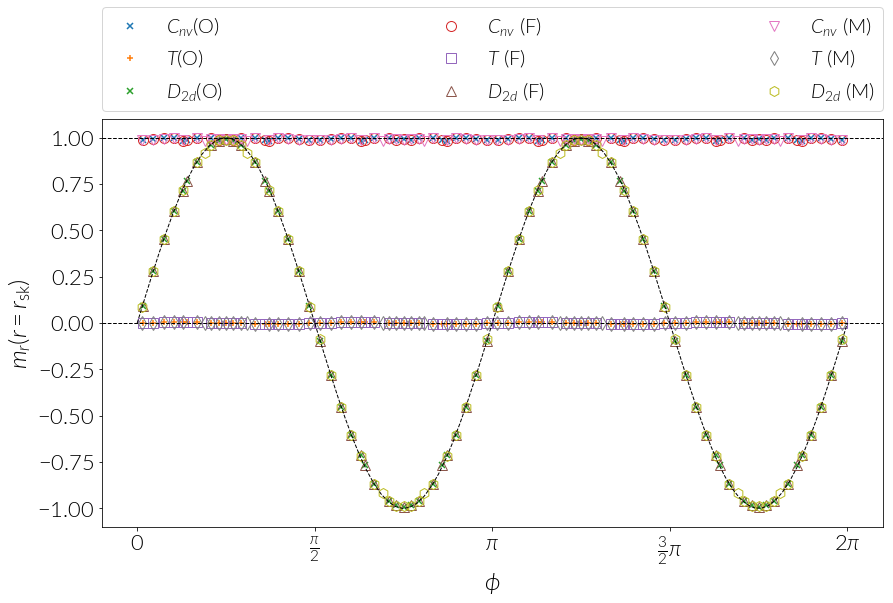

In [38]:
marks = ['x', '+', 'x', 'o', 's', '^', 'v', 'd', 'h']
labs = [r'$C_{nv}$', r'$T$', r'$D_{2d}$']

f = plt.figure(figsize=(14, 12/1.6))
ax = f.add_subplot(111)

# OOMMF
for i in range(3):
    ax.plot(phi_ring_oommf[i], mr_ring_oommf[i], marker=marks[i], ls='',
            label=labs[i] + '(O)', mew=1.5)

# Fidimag
for i in range(3):
    ax.plot(phi_ring_fidimag[i], mr_ring_fidimag[i], marker=marks[i + 3],
            markerfacecolor='None', ms=10, ls='', label=labs[i] + ' (F)', mew=1.)

# MuMax3
for i in range(3):
    ax.plot(phi_ring_mumax[i], mr_ring_mumax[i], marker=marks[i + 6],
            markerfacecolor='None', ms=10, ls='', label=labs[i] + ' (M)', mew=1.)

    
phi = np.linspace(0, 2 * np.pi, 100)
plt.plot(phi, np.sin(2 * phi), '--k', lw=1)
ax.axhline(y=0, lw=1, ls='--', color='k')
ax.axhline(y=1, lw=1, ls='--', color='k')

ax.legend(ncol=3, loc='lower left', bbox_to_anchor=(0, 1.02, 1., 1),
          mode='expand', borderaxespad=0., fontsize=20)

ax.set_xticks([0., .5 * np.pi, np.pi, 1.5 * np.pi, 2 * np.pi])
ax.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$",
                        r"$\frac{3}{2}\pi$", r"$2\pi$"])
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$m_{r}(r=r_{\mathrm{sk}})$')

plt.savefig('result_2d_mr_codes-comparison.pdf', bbox_inches='tight')

Maximum error relative to the analytical solutions:

In [39]:
labs = [r'C_{nv}', r'T,\,O', r'D_{2d}']
sols = [lambda x: 1, lambda x: 0, lambda x: np.sin(2 * x)]

In [40]:
for i in range(3):
    mr, phi = np.array(mr_ring_oommf[i]), np.array(phi_ring_oommf[i])
    max_err = np.max(np.abs(mr - sols[i](phi)))
    err = Math( r'\mathrm{OOMMF}\quad'
               + r'\mathrm{max}\Delta m_{r}^{' + labs[i] 
               + r'} = \mathtt{' + '{:.2E}'.format(max_err) + r'}'
               )
    display(err)
    
    # .........................................................................
    
    mr, phi = np.array(mr_ring_fidimag[i]), np.array(phi_ring_fidimag[i])
    max_err = np.max(np.abs(mr - sols[i](phi)))
    err = Math( r'\mathrm{Fidimag}\quad'
               + r'\mathrm{max}\Delta m_{r}^{' + labs[i] 
               + r'} = \mathtt{' + '{:.2E}'.format(max_err) + r'}'
               )
    display(err)
    
    # .........................................................................
    
    mr, phi = np.array(mr_ring_mumax[i]), np.array(phi_ring_mumax[i])
    max_err = np.max(np.abs(mr - sols[i](phi)))
    err = Math( r'\mathrm{MuMax3}\quad'
               + r'\mathrm{max}\Delta m_{r}^{' + labs[i] 
               + r'} = \mathtt{' + '{:.2E}'.format(max_err) + r'}'
               )
    display(err)

    # .........................................................................

    print('\n')
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>